Epoch: 1, Time Spent: 281.09s, Accuracy: 86.99%
Epoch: 2, Time Spent: 534.27s, Accuracy: 91.48%


KeyboardInterrupt: 

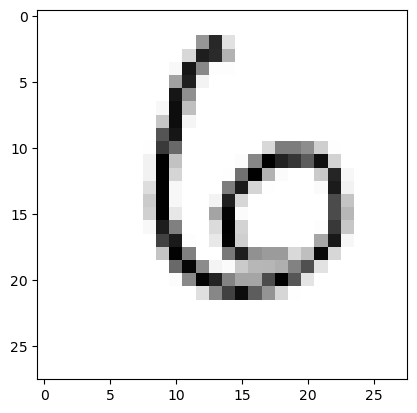

In [4]:
import numpy as np
import time
import matplotlib.pyplot
from scipy.ndimage import rotate, shift
%matplotlib inline

def rotate_image(image, angle):
    return rotate(image.reshape(28, 28), angle, reshape=False).flatten()

def shift_image(image, shift_val):
    return shift(image.reshape(28, 28), shift_val).flatten()
def flip_image(image, flip_axis):
    return np.flip(image.reshape(28, 28), axis=flip_axis).flatten()

def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()
convert("/home/aditi/Downloads/train-images.idx3-ubyte", "/home/aditi/Downloads/train-labels.idx1-ubyte","/home/aditi/Downloads/train.csv", 60000)
convert("/home/aditi/Downloads/t10k-images.idx3-ubyte", "/home/aditi/Downloads/t10k-labels.idx1-ubyte","/home/aditi/Downloads/test.csv", 10000)

train_file = open("/home/aditi/Downloads/train.csv", 'r')
train_list = train_file.readlines()
train_file.close()


len(train_list)


train_list[100]
augmented_train_list = []
k=1
for x in train_list:
    
    all_values = x.split(',')
    image = np.asfarray(all_values[1:])
    # Original image
    normalized_image = (image / 255.0 * 0.99) + 0.01  # Normalize the original image
    #augmented_train_list.append(','.join([all_values[0]] + [str(pix) for pix in normalized_image]))
    # Rotate by 10 degrees
    if k<2500:
        rotated_image = rotate_image(normalized_image, 10)
        augmented_train_list.append(','.join([all_values[0]] + [str(pix) for pix in rotated_image]))
    # Shift by 5 pixels
    elif k<2500:
        shifted_image = shift_image(normalized_image, 5)
        augmented_train_list.append(','.join([all_values[0]] + [str(pix) for pix in shifted_image]))
    elif k<2500:
        # Flip horizontally
        flipped_image = flip_image(normalized_image, 1)
        augmented_train_list.append(','.join([all_values[0]] + [str(pix) for pix in flipped_image]))
    else :
        break
    k=k+1
    

# Combine original and augmented data
train_list += augmented_train_list

# Update the number of images
num_images = len(train_list)
#print("Total number of images after augmentation:", num_images)


# pixel value to float, rearrange it into a 28*28 array and plot it as an image
all_values = train_list[100].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')


scaled_input_train = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

test_file = open("/home/aditi/Downloads/test.csv", 'r')
test_list = test_file.readlines()
test_file.close()

# str to float - pixel, rearrange it into a 28*28 array and plot it as an image
all_values = test_list[100].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

# scale input to range 0.01 to 1.00
scaled_input_test = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01



class DNN:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

   
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    output_layer=self.sizes[3]

    self.params = {
        'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
  def sigmoid(self, x, derivative=False):
      if derivative:
          return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1 + np.exp(-x))

  def softmax(self, x, derivative=False):
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)
  def forward_pass(self, x_train):
      params = self.params

     
      params['A0'] = x_train

      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.sigmoid(params['Z1'])

     
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.sigmoid(params['Z2'])

     
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.softmax(params['Z3'])

      return params['A3']

  def backward_pass(self, y_train, output):
     
      params = self.params
      change_w = {}

      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

    
      error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      
      error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w

  def update_network_parameters(self, changes_to_w):
      
      
      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value

  def compute_accuracy(self, test_data, output_nodes):
     
      predictions = []

      for x in train_list:
          all_values = x.split(',')
          # scale and shift the inputs
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          # create the target output values (all 0.01, except the desired label which is 0.99)
          targets = np.zeros(output_nodes) + 0.01
          # all_values[0] is the target label for this record
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))
      
      return np.mean(predictions)

  def train(self, train_list, test_list, output_nodes):
      start_time = time.time()
      for iteration in range(self.epochs):
          for x in train_list:
              all_values = x.split(',')
              # scale and shift the inputs
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              # create the target output values (all 0.01, except the desired label which is 0.99)
              targets = np.zeros(output_nodes) + 0.01
              # all_values[0] is the target label for this record
              targets[int(all_values[0])] = 0.99
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)
          
          accuracy = self.compute_accuracy(test_list, output_nodes)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))
          
dnn = DNN(sizes=[784, 256, 128, 10], epochs=13, lr=0.84)
dnn.train(train_list, test_list, 10) 